In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using LinearAlgebra
using Flux, DiffEqFlux
using Optim
using Plots
using ProgressMeter
using Random
using DifferentialEquations: DP5, Tsit5, BS3, Vern7
using NLopt
ProgressMeter.ijulia_behavior(:clear)

false

In [2]:
bs = SpinBasis(1//2)
sx = sigmax(bs)
ni = 0.5*(identityoperator(bs) + sigmaz(bs));

In [3]:
V = 2π*24.0
δe = -2π*4.5

-28.274333882308138

In [4]:
n_atoms = 4
bsys = tensor([bs for i in 1:n_atoms]...);

In [5]:
H0 = V*sum([embed(bsys, [i, j], [ni, ni])/abs(i-j)^6  for i in 1:n_atoms for j in i+1:n_atoms])
H0 -= δe*sum([embed(bsys, [i], [ni]) for i in [1, n_atoms]]);

In [6]:
H1 = 0.5*sum([embed(bsys, [i], [sx]) for i in 1:n_atoms])
H2 = -sum([embed(bsys, [i], [ni]) for i in 1:n_atoms]);

In [7]:
function GHZ_state(n_atoms)
    state = tensor([spindown(bs)⊗spinup(bs) for i in 1:Int(n_atoms/2)]...) +
            tensor([spinup(bs)⊗spindown(bs) for i in 1:Int(n_atoms/2)]...)
    state/sqrt(2.0)
end 

ground_state(n_atoms) = tensor([spindown(bs) for i in 1:n_atoms]...)
trans = StateTransform(ground_state(n_atoms)=>GHZ_state(n_atoms));

In [8]:
n_neurons = 8
sigmoid(x)= @. 2π*7 / (1 + exp(-x))
Random.seed!(10)
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, 2))
θ = initial_params(ann)  
n_params = length(θ)

106

In [9]:
t0, t1 = 0.0, 0.5

tsf32 = Float32(t0):Float32(t1/49):Float32(t1)
Ωs = Vector{Float32}(2π*vcat(0:0.5:4, 5*ones(32), 4:-0.5:0))
Δs = Vector{Float32}(2π*(-5:10/49:5))
ts = Vector{Float64}(tsf32)

function loss(p)
    c = 0.0f0
    for (i,t) in enumerate(tsf32)
        x = ann([t], p)
        c += (abs(x[1]) - Ωs[i])^2
        c += (x[2] - Δs[i])^2
    end
    #println(c)
    c
end

res = DiffEqFlux.sciml_train(loss, initial_params(ann), ADAM(0.1f0), maxiters = 5000)
θ = Vector{Float64}(res.u);

In [10]:
coeffs(params, t) = let vals = ann([t], params)
                        [abs(vals[1]), vals[2]]
                    end    

cost = CostFunction((x, y) -> 1-real(-x'*y),
                     p->2e-3*(abs(ann([t0], p)[1])+ 5.0*abs(ann([t1], p)[1])))

CostFunction(var"#19#21"(), var"#20#22"())

In [11]:
H = Hamiltonian(H0, [H1, H2], coeffs);

In [12]:
prob = QOCProblem(H, trans, (t0, t1), cost);

In [13]:
sol = solve(prob, θ, ADAM(0.005); alg=Tsit5(), maxiters=400, abstol=1e-6, reltol=1e-6)
sol1 = solve(prob, sol.params, ADAM(0.01); alg=Tsit5(), maxiters=1400, abstol=1e-6, reltol=1e-6)

Progress: 100%|█████████████████████████████████████████| Time: 0:12:30
  distance:    0.005928688153393313
  contraints:  0.00025603757548815054


Solution{Float64}([-4.533038381196078, -4.060239429547267, 4.697051199805303, -6.878911748599934, -12.228354740472431, -12.96481761383911, 14.178344532726321, -4.497189954147079, 1.6097747399922673, 1.656143799646488  …  1.5323107481654914, -4.950510562070213, 3.602619489969659, -2.9399852530392363, -4.459014977437479, 17.383594961774797, 20.038962875262555, 5.0659012043020395, 4.303666129053518, 1.8357233343737909], [0.23853096080083946, 0.31500394955225386, 0.24704456779706996, 0.28511575556042223, 0.26599572866791354, 0.24300074526924553, 0.2508537987766646, 0.25855332677875575, 0.2478478308728458, 0.23677083887912465  …  0.006124089533645072, 0.006047903300677948, 0.005981436640311255, 0.005998641370353219, 0.00598280810101115, 0.005989156983792654, 0.006089812402953809, 0.006094892411763642, 0.005985635712367765, 0.005928688153393313])

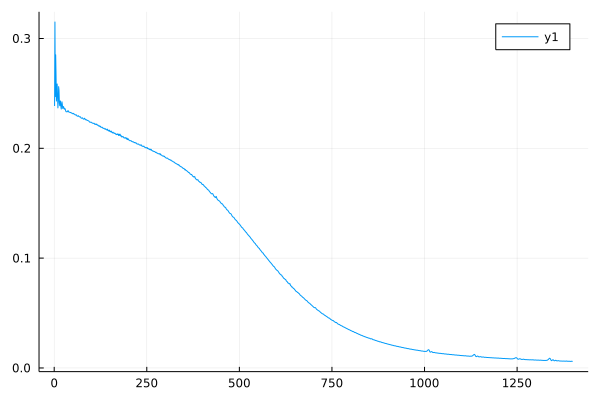

In [14]:
plot(sol1.trace)

In [28]:
Ω(t) = abs(ann([t], sol1.params)[1])/2π
Δ(t) = ann([t], sol1.params)[2]/2π

ts = t0:0.001:t1
f = plot(ts, Ω.(ts), label="Ω/2π")
plot!(f, ts, Δ.(ts), label="Δ/2π", legend=:topleft)
xlabel!(f, "Time (µs)")
ylabel!(f, "Frequency (MHz)")
savefig(f,"GHZ_4_atoms_wfs.svg")

In [21]:
tout, psit = schroedinger_dynamic(ts, ground_state(n_atoms), H, sol1.params);

In [27]:
f = plot(tout, real(expect(dm(GHZ_state(n_atoms)), psit)),  legend = false)
ylabel!(f, "Overlap")
xlabel!(f, "Time (µs)")
savefig(f,"GHZ_4_atoms_overlap.svg")